#IMPORTS

In [4]:
import pandas as pd
import requests
import numpy as np
import yfinance as yf
import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

import scipy.fftpack

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from transformers import pipeline


#APPLE DATA

In [5]:
apple_ticker = 'AAPL'
df = yf.download(apple_ticker, start='2015-01-01', end='2024-08-31', progress=False)
print(df.head())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.373955  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.687302  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.689531  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.021715  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  24.944683  237458000


In [6]:
df.to_csv('AAPL_historical.csv')

In [7]:
print('There are {} number of days in the dataset.'.format(df.shape[0]))
total_days = df.shape[0]
train_days = int(total_days * 0.7)
test_days = total_days - train_days

print(f"Training data days: {train_days}")
print(f"Test data days: {test_days}")


There are 2429 number of days in the dataset.
Training data days: 1700
Test data days: 729


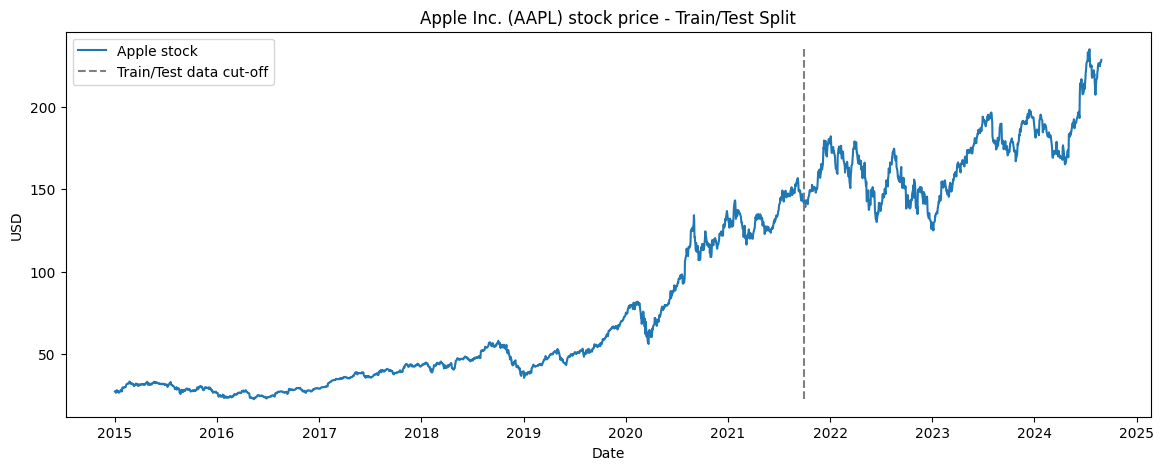

In [8]:
import matplotlib.pyplot as plt
import datetime

train_end_date = df.index[train_days - 1]

plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df.index, df['Close'], label='Apple stock')

plt.vlines(train_end_date, ymin=df['Close'].min(), ymax=df['Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')

plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Apple Inc. (AAPL) stock price - Train/Test Split')
plt.legend()
plt.show()


##CORRELATED ASSETS






In [9]:
correlated_assets = [
    'MSFT', 'GOOGL', 'AMZN', 'FB', 'NFLX', 'NVDA', 'TSLA', 'AMD', 'INTC',
    'QCOM', 'CSCO', 'ORCL', 'IBM', 'HPQ', 'DELL', 'BABA', 'TSM', 'V', 'MA',
    'ADBE', 'CRM', 'PYPL', 'SQ', 'SHOP', 'TWTR', 'SPY', 'QQQ', 'DIA', 'IWM',
    'VGT', 'XLK', 'XLY', 'XLV', 'XLF', 'XLC', 'XLI', 'XLE', 'XLP', 'XLU',
    'VTI', 'VOO', 'IVV', 'ARKK', 'ARKG', 'ARKW', 'ARKF', 'TQQQ', 'SOXX'
]

In [10]:
asset_data = {}
failed_assets = []

for asset in correlated_assets:
    try:
        df = yf.download(asset, start='2015-01-01', end='2024-08-31', progress=False)
        if not df.empty:
            asset_data[asset] = df['Close']
        else:
            print(f"No data found for {asset}")
            failed_assets.append(asset)
    except Exception as e:
        print(f"Failed to download data for {asset}: {e}")
        failed_assets.append(asset)

correlated_df = pd.DataFrame(asset_data)
correlated_df.dropna(inplace=True)

print(f"Failed to download data for the following assets: {failed_assets}")


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for FB


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWTR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for TWTR
Failed to download data for the following assets: ['FB', 'TWTR']


In [11]:
print(correlated_df.head())
print(f"DataFrame shape: {correlated_df.shape}")

                  MSFT      GOOGL       AMZN        NFLX     NVDA       TSLA  \
Date                                                                           
2019-02-04  105.739998  57.070999  81.665497  351.339996  3.72950  20.859333   
2019-02-05  107.220001  57.593498  82.940498  355.809998  3.74875  21.423332   
2019-02-06  106.029999  56.144501  82.013000  352.190002  3.82500  21.148001   
2019-02-07  105.269997  55.295502  80.718498  344.709991  3.68550  20.500668   
2019-02-08  105.669998  55.118999  79.411003  347.570007  3.70425  20.386667   

                  AMD       INTC       QCOM       CSCO  ...        XLU  \
Date                                                    ...              
2019-02-04  24.129999  49.220001  49.689999  47.349998  ...  54.639999   
2019-02-05  23.309999  50.009998  50.730000  47.259998  ...  54.750000   
2019-02-06  23.260000  49.900002  51.099998  47.480000  ...  54.720001   
2019-02-07  22.670000  49.230000  50.549999  46.700001  ...  55.43999

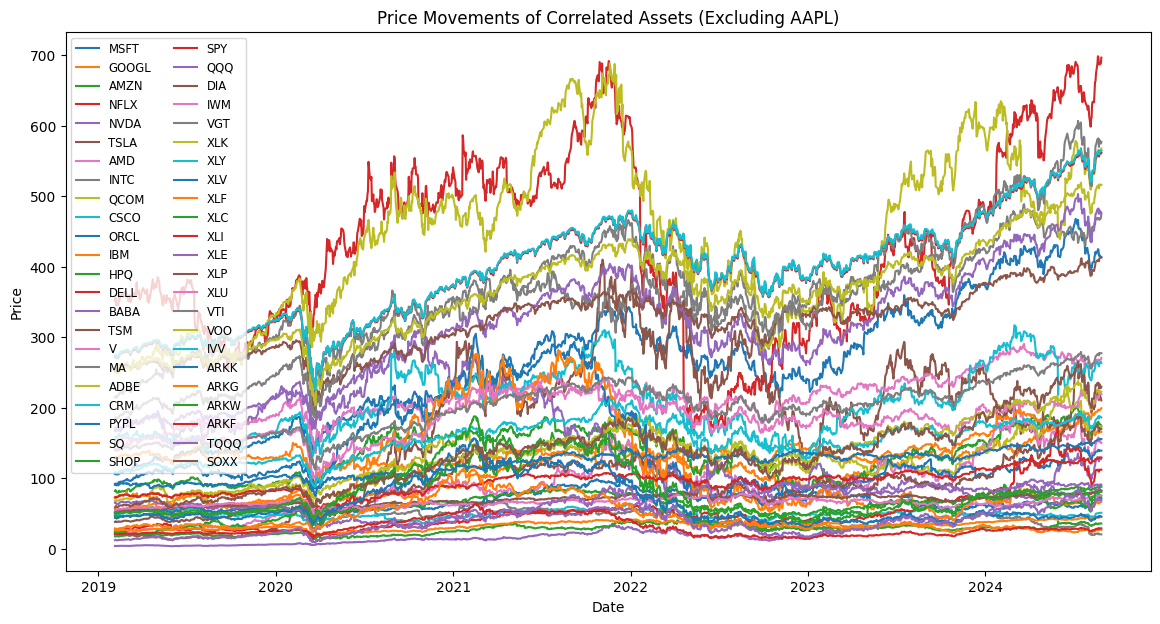

In [12]:
plt.figure(figsize=(14, 7))
for column in correlated_df.columns:
    plt.plot(correlated_df.index, correlated_df[column], label=column)

plt.title('Price Movements of Correlated Assets (Excluding AAPL)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.show()

##TECHNICAL INDICATORS

In [13]:
df = pd.read_csv('AAPL_historical.csv', parse_dates=['Date'], index_col='Date')

def calculate_technical_indicators(df):
    df.sort_index(inplace=True)

    #7-day and 21-day Simple Moving Averages (SMA)
    df['SMA_7'] = df['Close'].rolling(window=7).mean()
    df['SMA_21'] = df['Close'].rolling(window=21).mean()

    #12-day and 26-day Exponential Moving Averages (EMA)
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

    #MACD and Signal line
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    #14-day RSI
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    #Bollinger Bands
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['BB_Upper'] = df['SMA_20'] + (df['Close'].rolling(window=20).std() * 2)
    df['BB_Lower'] = df['SMA_20'] - (df['Close'].rolling(window=20).std() * 2)

    #Momentum
    df['Momentum'] = df['Close'].diff(4)

    #Log Momentum
    df['Log_Momentum'] = np.log(df['Close'] / df['Close'].shift(4))

    return df

technical_indicators_df = calculate_technical_indicators(df.copy())

print(technical_indicators_df[['Close', 'SMA_7', 'SMA_21', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14', 'BB_Upper', 'BB_Lower', 'Momentum', 'Log_Momentum']].tail())


                 Close       SMA_7      SMA_21      EMA_12      EMA_26  \
Date                                                                     
2024-08-21  226.399994  224.651428  218.918573  222.377632  220.331060   
2024-08-22  224.529999  225.117142  219.203811  222.708765  220.642093   
2024-08-23  226.839996  225.848570  219.649049  223.344339  221.101197   
2024-08-26  227.179993  226.199997  220.088096  223.934440  221.551478   
2024-08-27  228.375000  226.532139  220.570714  224.617603  222.056924   

                MACD  MACD_Signal     RSI_14    BB_Upper    BB_Lower  \
Date                                                                   
2024-08-21  2.046572     1.006336  61.879419  230.433714  207.441289   
2024-08-22  2.066673     1.218404  56.825486  231.027666  207.551336   
2024-08-23  2.243143     1.423351  83.879650  231.923023  207.543978   
2024-08-26  2.382962     1.615274  91.167975  232.787931  207.573069   
2024-08-27  2.560679     1.804355  90.628420  233

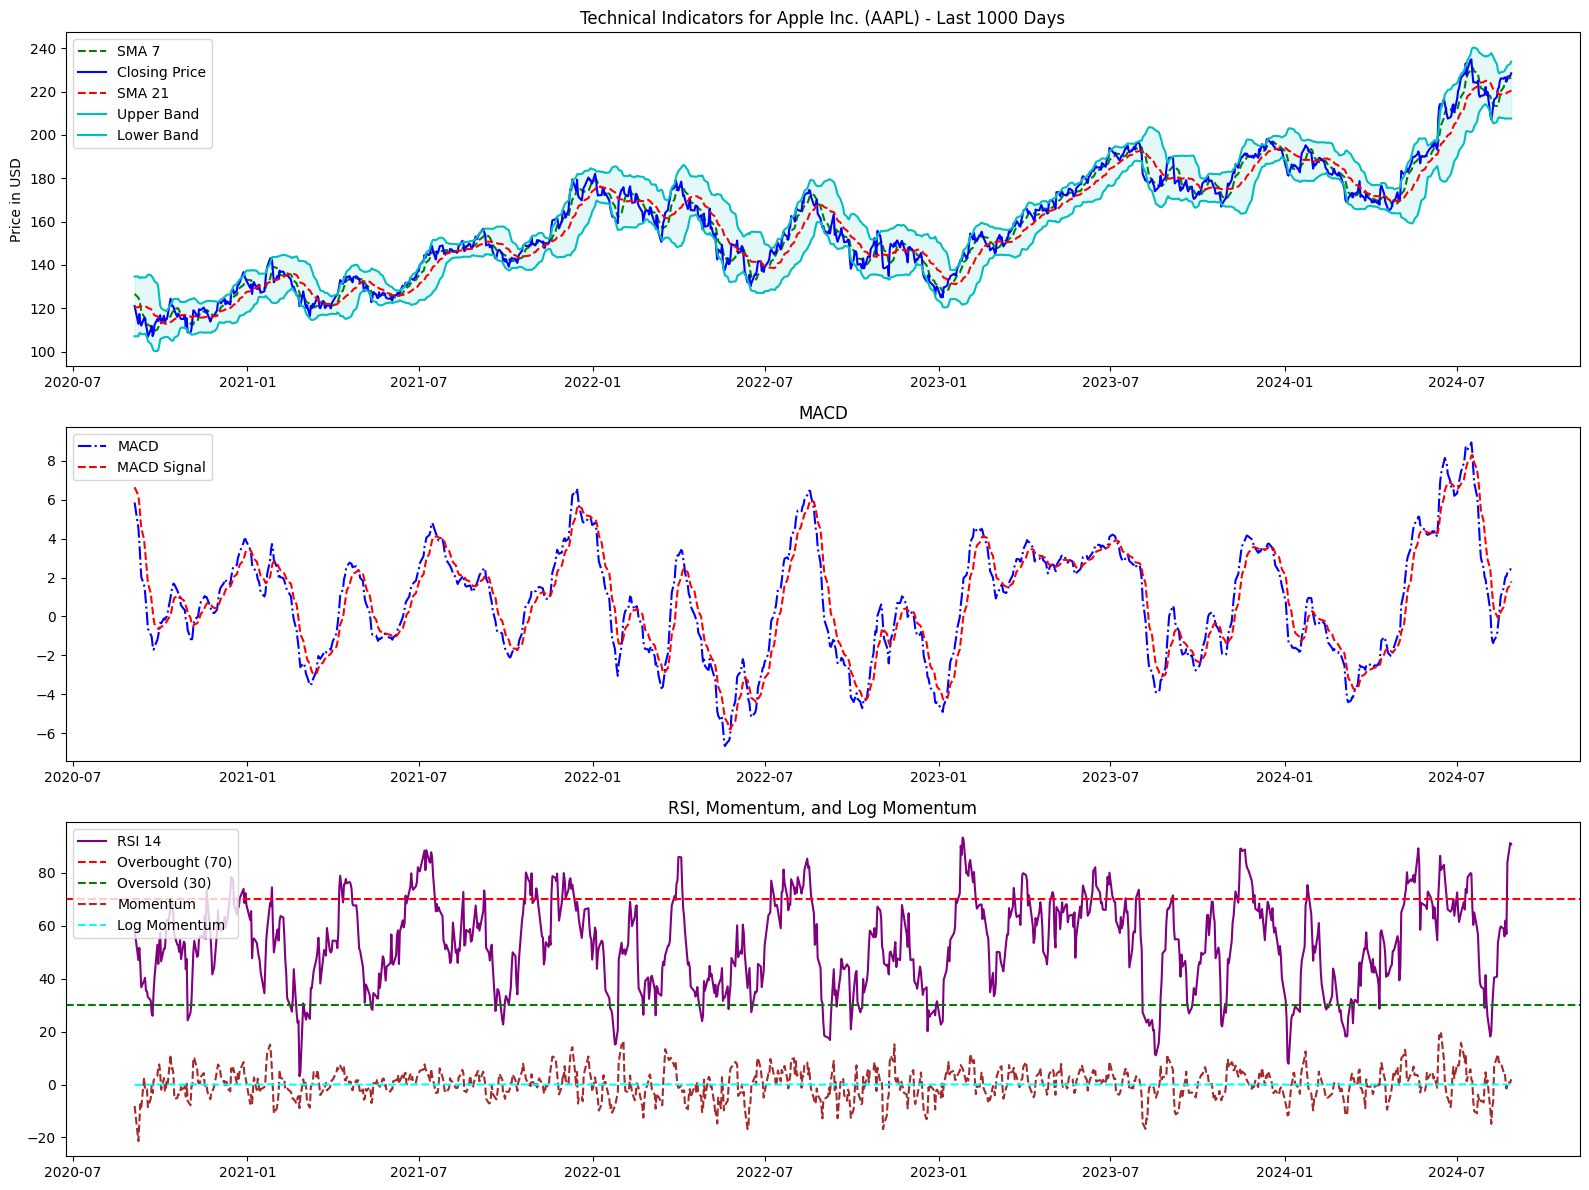

In [14]:
import matplotlib.pyplot as plt

def plot_technical_indicators(dataset, last_days):
    dataset = dataset.sort_index()
    dataset = dataset.iloc[-last_days:, :]
    x_ = list(dataset.index)

    plt.figure(figsize=(16, 12), dpi=100)
    plt.subplot(3, 1, 1)
    plt.plot(dataset['SMA_7'], label='SMA 7', color='g', linestyle='--')
    plt.plot(dataset['Close'], label='Closing Price', color='b')
    plt.plot(dataset['SMA_21'], label='SMA 21', color='r', linestyle='--')
    plt.plot(dataset['BB_Upper'], label='Upper Band', color='c')
    plt.plot(dataset['BB_Lower'], label='Lower Band', color='c')
    plt.fill_between(x_, dataset['BB_Lower'], dataset['BB_Upper'], color='c', alpha=0.1)
    plt.title('Technical Indicators for Apple Inc. (AAPL) - Last {} Days'.format(last_days))
    plt.ylabel('Price in USD')
    plt.legend(loc='upper left')

    plt.subplot(3, 1, 2)
    plt.plot(dataset['MACD'], label='MACD', color='blue', linestyle='-.')
    plt.plot(dataset['MACD_Signal'], label='MACD Signal', color='red', linestyle='--')
    plt.title('MACD')
    plt.legend(loc='upper left')

    plt.subplot(3, 1, 3)
    plt.plot(dataset['RSI_14'], label='RSI 14', color='purple')
    plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    plt.plot(dataset['Momentum'], label='Momentum', color='brown', linestyle='--')
    plt.plot(dataset['Log_Momentum'], label='Log Momentum', color='cyan', linestyle='--')
    plt.title('RSI, Momentum, and Log Momentum')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_technical_indicators(technical_indicators_df, last_days=1000)

#FOURIER TRANSFORMS FOR TREND ANALYSIS

In [27]:
import scipy.fftpack
import numpy as np

def calculate_fourier_transform(df):
    close_fft = np.fft.fft(np.asarray(df['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fourier_df = pd.DataFrame()
    for num_ in [3, 6, 9, 100]:
        fft_list_m10 = np.copy(close_fft)
        fft_list_m10[num_:-num_] = 0
        fourier_df[f'Fourier_{num_}'] = np.abs(np.fft.ifft(fft_list_m10))

    fourier_df['Date'] = df.index
    fourier_df.set_index('Date', inplace=True)

    return fourier_df

fourier_df = calculate_fourier_transform(df.copy())

print(fourier_df.tail())

             Fourier_3   Fourier_6   Fourier_9  Fourier_100
Date                                                       
2024-08-21  113.148064  119.166386  125.531793   193.920758
2024-08-22  112.786977  118.366167  124.396953   181.388183
2024-08-23  112.425518  117.565317  123.258834   167.536042
2024-08-26  112.063694  116.763903  122.117639   152.637822
2024-08-27  111.701513  115.961994  120.973571   137.010450


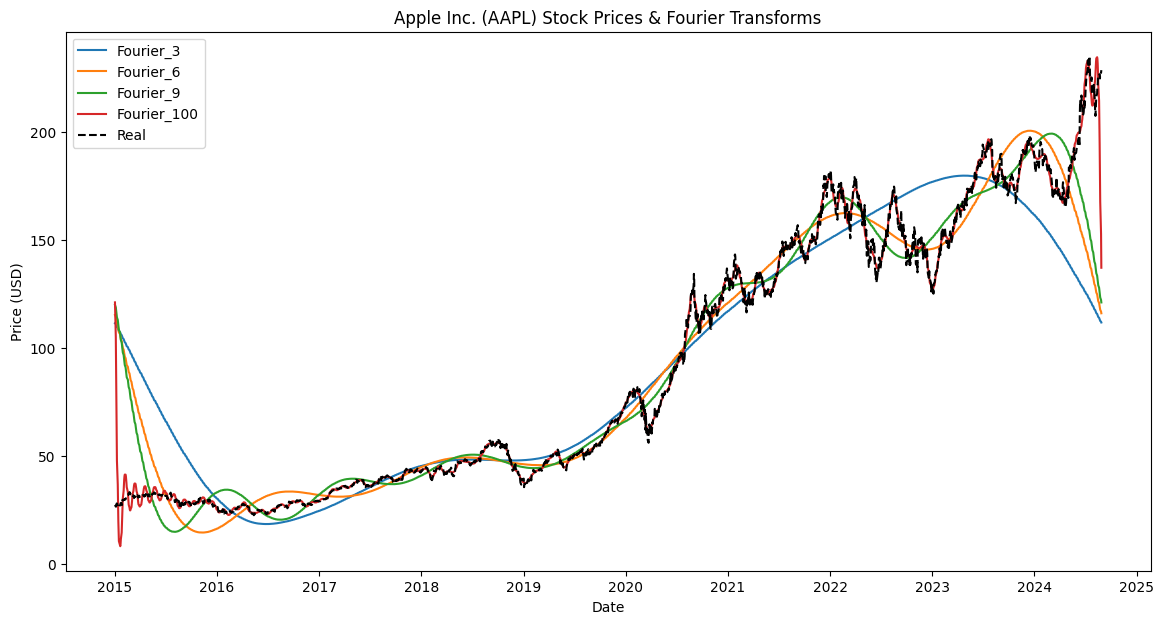

In [28]:
import matplotlib.pyplot as plt

def plot_fourier_transforms(fourier_df, original_df):
    plt.figure(figsize=(14, 7), dpi=100)

    for column in fourier_df.columns:
        plt.plot(fourier_df.index, np.real(fourier_df[column]), label=column)

    plt.plot(original_df.index, original_df['Close'], label='Real', color='black', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title('Apple Inc. (AAPL) Stock Prices & Fourier Transforms')
    plt.legend()
    plt.show()

plot_fourier_transforms(fourier_df, df)


#ARIMA

In [17]:
arima_df = df.copy()

In [18]:
series = arima_df['Close']

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2429
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5035.638
Date:                Tue, 27 Aug 2024   AIC                          10083.277
Time:                        18:54:31   BIC                          10118.046
Sample:                             0   HQIC                         10095.918
                               - 2429                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0165      0.013     -1.300      0.194      -0.041       0.008
ar.L2         -0.0158      0.014     -1.157      0.247      -0.042       0.011
ar.L3         -0.0152      0.014     -1.051      0.2

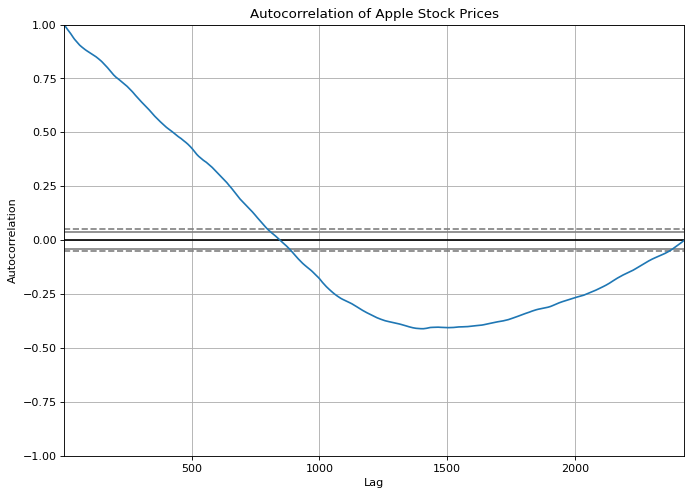

In [19]:
plt.figure(figsize=(10, 7), dpi=80)
autocorrelation_plot(series)
plt.title('Autocorrelation of Apple Stock Prices')
plt.show()

In [20]:
series = arima_df['Close']
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

In [21]:
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


Test MSE: 7.668


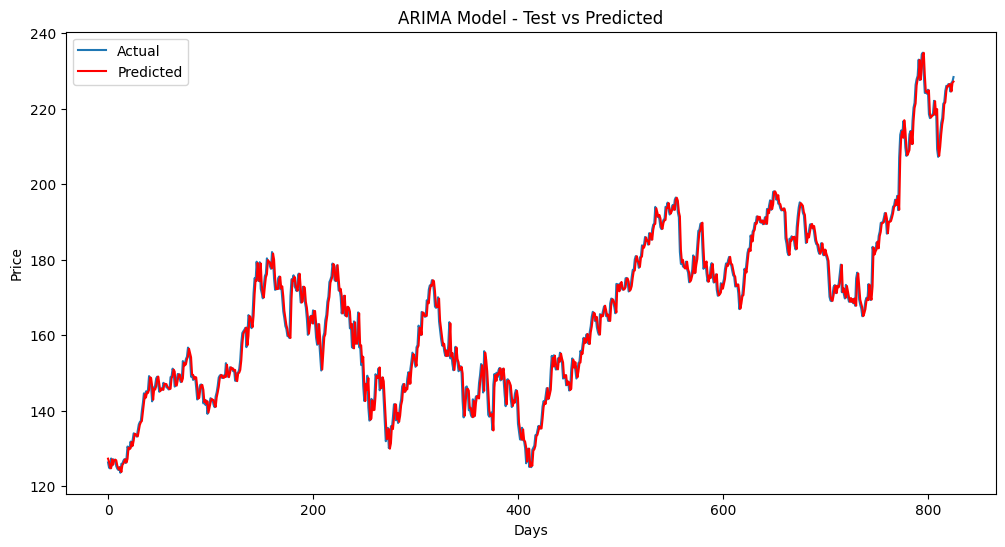

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('ARIMA Model - Test vs Predicted')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

#Heteroskedasticity, multicollinearity, and serial correlation check

##MERGE DATAFRAMES

In [29]:
import pandas as pd
import numpy as np

base_df = df.copy()

correlated_df.index = pd.to_datetime(correlated_df.index)
dataset_total_df = base_df.join(correlated_df, how='inner', rsuffix='_asset')

technical_indicators_df.index = pd.to_datetime(technical_indicators_df.index)
dataset_total_df = dataset_total_df.join(technical_indicators_df, how='inner', rsuffix='_tech')

fourier_df.index = pd.to_datetime(fourier_df.index)
dataset_total_df = dataset_total_df.join(fourier_df, how='inner', rsuffix='_fft')

arima_df.index = pd.to_datetime(arima_df.index)
dataset_total_df = dataset_total_df.join(arima_df, how='inner', rsuffix='_arima')

print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], dataset_total_df.shape[1]))


Total dataset has 1401 samples, and 80 features.


In [30]:
dataset_total_df.to_csv('AAPL_combined_features.csv')

#FEATURE IMPORTANCE

In [43]:
def get_feature_importance_data(data):
    data = data.copy()
    y = data['Close']
    X = data.drop(columns=['Close'])

    train_samples = int(X.shape[0] * 0.65)

    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]

    return (X_train, y_train), (X_test, y_test)

(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_total_df)


In [45]:
import xgboost as xgb
import matplotlib.pyplot as plt

regressor = xgb.XGBRegressor(gamma=0.0, n_estimators=150, base_score=0.7, colsample_bytree=1, learning_rate=0.05)

xgbModel = regressor.fit(X_train_FI, y_train_FI,
                         eval_set=[(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)],
                         verbose=False)

eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))


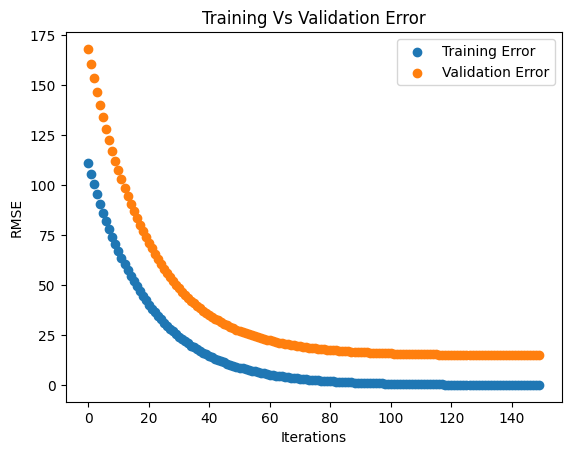

In [46]:
plt.scatter(x=training_rounds, y=eval_result['validation_0']['rmse'], label='Training Error')
plt.scatter(x=training_rounds, y=eval_result['validation_1']['rmse'], label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

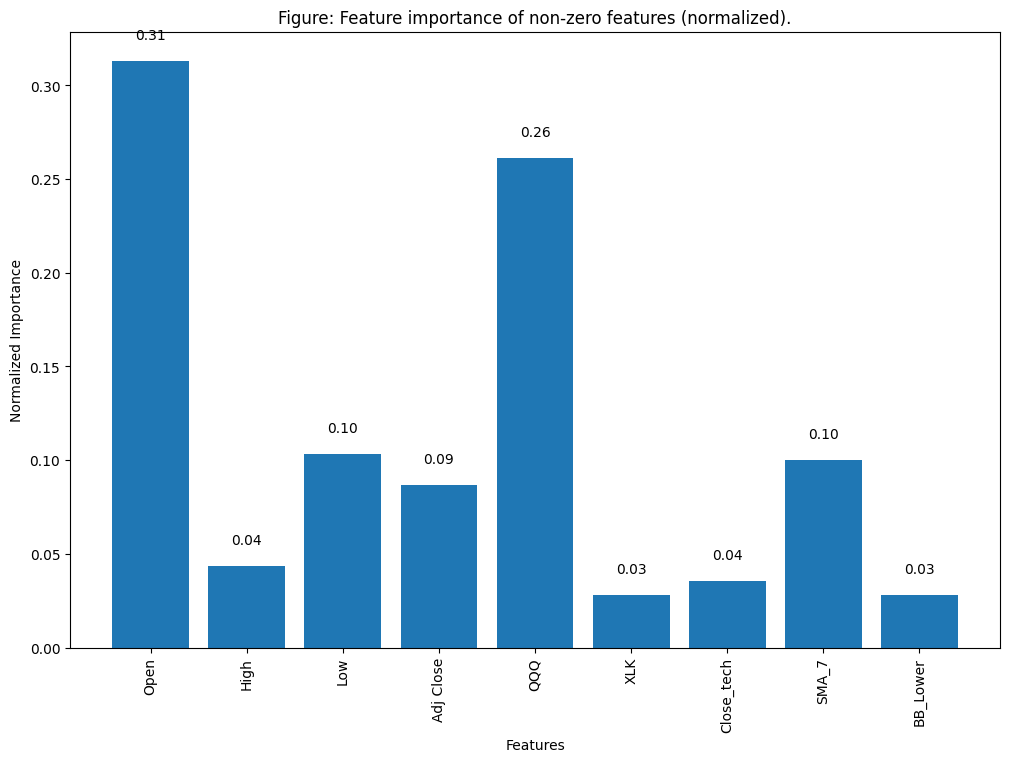

In [47]:
import matplotlib.pyplot as plt

feature_importances = xgbModel.feature_importances_
non_zero_indices = feature_importances > 0.01
filtered_importances = feature_importances[non_zero_indices]
filtered_features = X_test_FI.columns[non_zero_indices]

normalized_importances = filtered_importances / filtered_importances.sum()

fig = plt.figure(figsize=(12, 8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(normalized_importances))],
        normalized_importances.tolist(),
        tick_label=filtered_features)

for i, v in enumerate(normalized_importances):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

plt.title('Figure: Feature importance of non-zero features (normalized).')
plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.show()


#LSTM MODEL

In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset_total_df)

In [58]:
target_column_index = 4
y = scaled_data[:, target_column_index]

X = np.delete(scaled_data, target_column_index, axis=1)


In [59]:
timesteps = 60
X_lstm = []
y_lstm = []

for i in range(timesteps, len(X)):
    X_lstm.append(X[i-timesteps:i])
    y_lstm.append(y[i])

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.3, shuffle=False)

In [68]:
!pip install optuna
!pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 3.2 MB/s eta 0:00:00


In [69]:
import optuna
from optuna.integration import KerasPruningCallback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import Callback

def create_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [70]:
def objective(trial):
    units = trial.suggest_int('units', 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    model = create_lstm_model(units=units, dropout_rate=dropout_rate)

    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(X_test, y_test))

    loss = model.evaluate(X_test, y_test, verbose=0)
    return loss

In [72]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Best Parameters: ", best_params)

[I 2024-08-27 19:45:41,499] A new study created in memory with name: no-name-6ccb5773-b2f8-4ae0-b788-7da2aec32fb6
[I 2024-08-27 19:46:36,621] Trial 0 finished with value: 0.008933547884225845 and parameters: {'units': 107, 'dropout_rate': 0.1236945858984469}. Best is trial 0 with value: 0.008933547884225845.
[I 2024-08-27 19:48:22,095] Trial 1 finished with value: 0.005916372872889042 and parameters: {'units': 194, 'dropout_rate': 0.39796924398683453}. Best is trial 1 with value: 0.005916372872889042.
[I 2024-08-27 19:50:04,335] Trial 2 finished with value: 0.00898843351751566 and parameters: {'units': 153, 'dropout_rate': 0.45899531475235145}. Best is trial 1 with value: 0.005916372872889042.
[I 2024-08-27 19:51:39,819] Trial 3 finished with value: 0.010450981557369232 and parameters: {'units': 169, 'dropout_rate': 0.1955281419627558}. Best is trial 1 with value: 0.005916372872889042.
[I 2024-08-27 19:52:09,085] Trial 4 finished with value: 0.007847113534808159 and parameters: {'units

Best Parameters:  {'units': 163, 'dropout_rate': 0.30736586798214915}


In [88]:
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))


In [87]:
class VisualizeTraining(Callback):
    def __init__(self, X_test, y_test, scaler, interval=5):
        self.X_test = X_test
        self.y_test = y_test
        self.scaler = scaler
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            predictions = self.model.predict(self.X_test)
            predictions = self.scaler.inverse_transform(predictions)
            y_test_inverse = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))

            plt.figure(figsize=(14, 7))
            plt.plot(y_test_inverse, label='Actual')
            plt.plot(predictions, label='Predicted')
            plt.title(f'Epoch {epoch + 1}: Actual vs Predicted')
            plt.xlabel('Time')
            plt.ylabel('Stock Price')
            plt.legend()
            plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - loss: 0.1438 - val_loss: 0.0624
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - loss: 0.0092 - val_loss: 0.0357
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.0049 - val_loss: 0.0220
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - loss: 0.0049 - val_loss: 0.0114
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - loss: 0.0035 - val_loss: 0.0174
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.0043 - val_loss: 0.0076
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - loss: 0.0035 - val_loss: 0.0102
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - loss: 0.0029 - val_loss: 0.0137
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - loss: 0.0031 - val_loss: 0.0123
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - loss: 0.0026 - val_loss: 0.0174
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - loss: 0.0030 - val_loss: 0.0125
Epoch 12/200
30/30 ━━━━━━━━━━━━━━━━━━

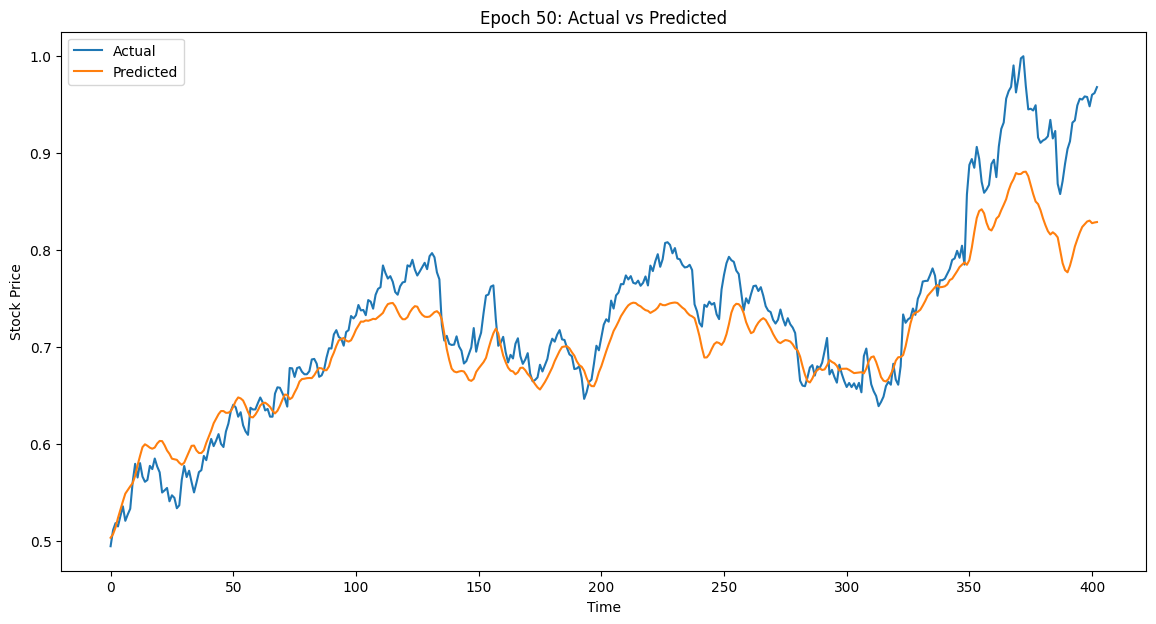

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 323ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 51/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - loss: 0.0017 - val_loss: 0.0132
Epoch 52/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - loss: 0.0015 - val_loss: 0.0073
Epoch 53/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - loss: 0.0013 - val_loss: 0.0060
Epoch 54/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - loss: 0.0013 - val_loss: 0.0087
Epoch 55/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 56/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 274ms/step - loss: 0.0015 - val_loss: 0.0074
Epoch 57/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 58/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 59/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - loss: 0.0014 - val_loss: 0.0055
Epoch 60/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 61/200
30/30 ━━━━━━━━━━━━━━━━━━━━

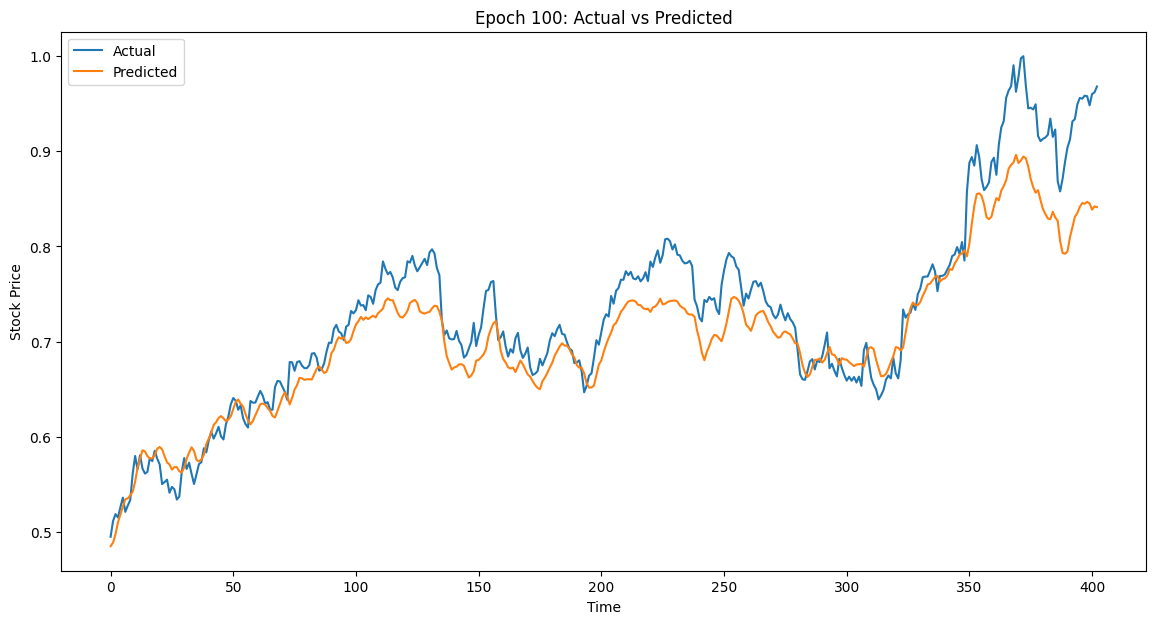

30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 322ms/step - loss: 8.5784e-04 - val_loss: 0.0032
Epoch 101/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 284ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 102/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 103/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 104/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - loss: 0.0013 - val_loss: 0.0082
Epoch 105/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - loss: 0.0013 - val_loss: 0.0065
Epoch 106/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 0.0010 - val_loss: 0.0074
Epoch 107/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - loss: 0.0010 - val_loss: 0.0077
Epoch 108/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - loss: 9.4472e-04 - val_loss: 0.0146
Epoch 109/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 110/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - loss: 9.8993e-04 - val_loss: 0.0045
Epoch 111/200
30/30

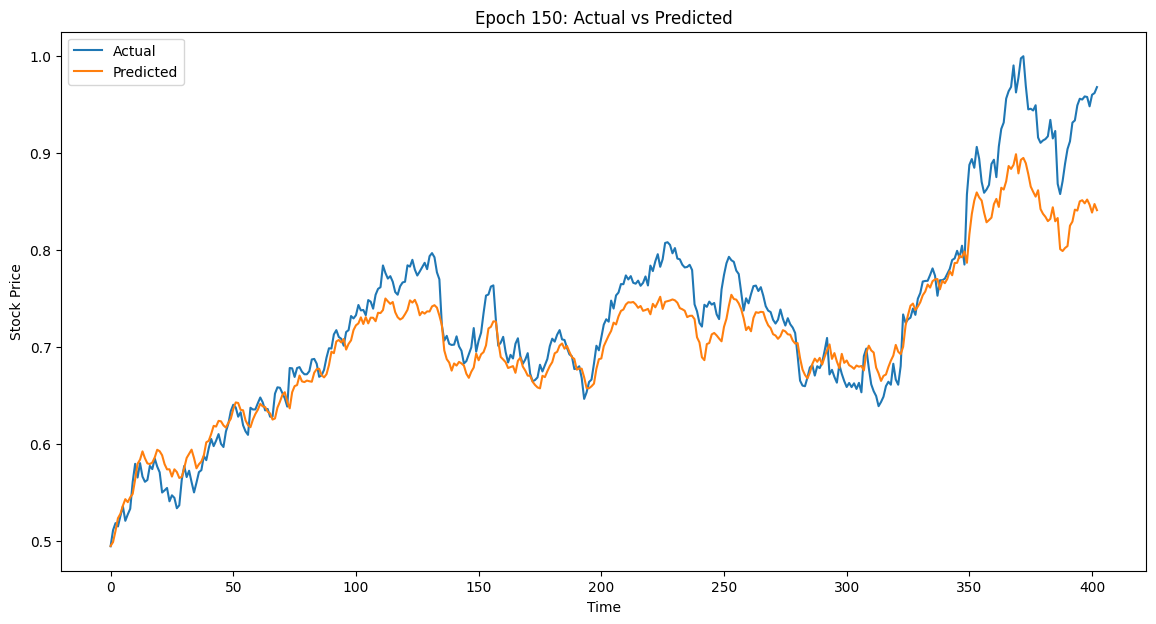

30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - loss: 8.5439e-04 - val_loss: 0.0028
Epoch 151/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - loss: 9.9791e-04 - val_loss: 0.0079
Epoch 152/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - loss: 9.9399e-04 - val_loss: 0.0024
Epoch 153/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - loss: 9.7516e-04 - val_loss: 0.0075
Epoch 154/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - loss: 9.8529e-04 - val_loss: 0.0046
Epoch 155/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - loss: 7.7763e-04 - val_loss: 0.0028
Epoch 156/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - loss: 9.5075e-04 - val_loss: 0.0027
Epoch 157/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 290ms/step - loss: 8.6955e-04 - val_loss: 0.0047
Epoch 158/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - loss: 9.4995e-04 - val_loss: 0.0066
Epoch 159/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - loss: 8.7743e-04 - val_loss: 0.0027
Epoch 160/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step - loss: 8.3821e-04 - val_

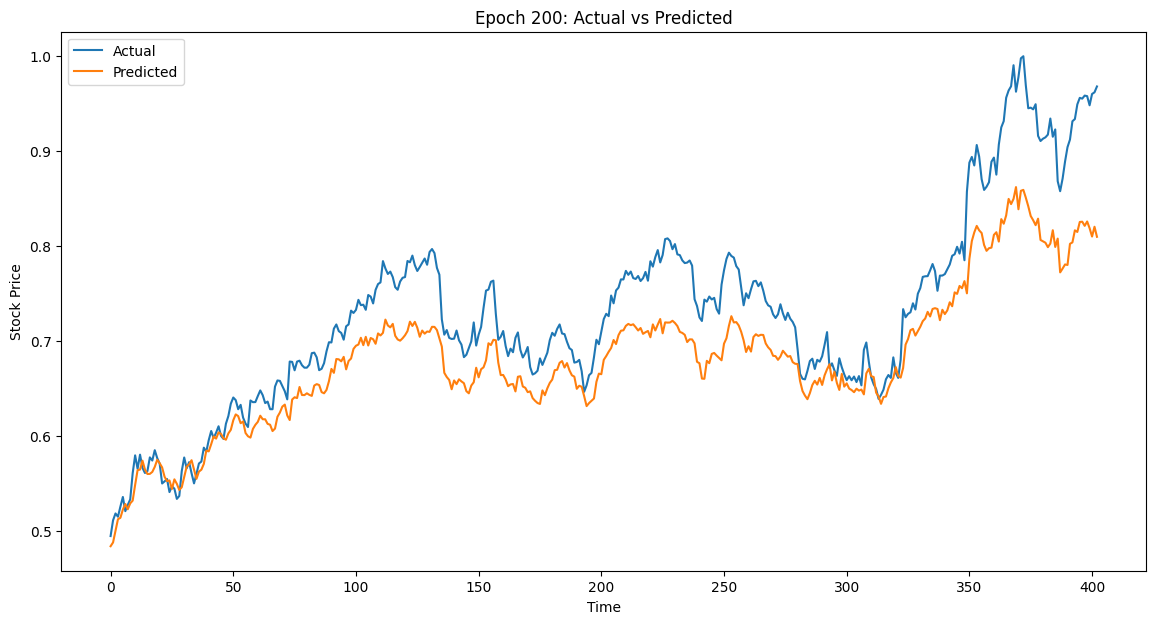

30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - loss: 9.2632e-04 - val_loss: 0.0065


In [82]:
# Train the final model using the best hyperparameters
final_model = create_lstm_model(units=best_params['units'], dropout_rate=best_params['dropout_rate'])

visualize_callback = VisualizeTraining(X_test, y_test_scaled, scaler, interval=50)

final_model.fit(X_train, y_train_scaled, epochs=200, batch_size=32, verbose=1,
                validation_data=(X_test, y_test_scaled), callbacks=[visualize_callback])

#FINAL RESULTS

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

final_predictions = final_model.predict(X_test)

final_predictions = scaler.inverse_transform(final_predictions)
y_test_inverse = scaler.inverse_transform(y_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_inverse, final_predictions))
mae = mean_absolute_error(y_test_inverse, final_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
RMSE: 0.05728207888910277
MAE: 0.04666392315494417


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


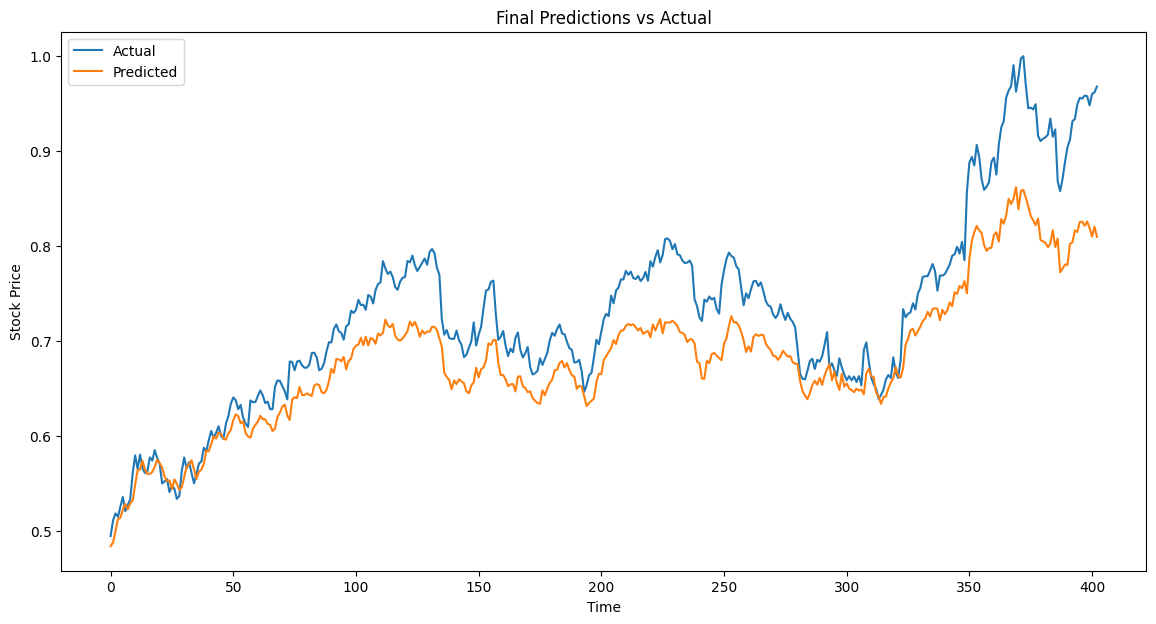

In [83]:
final_predictions = final_model.predict(X_test)
final_predictions = scaler.inverse_transform(final_predictions)
y_test_inverse = scaler.inverse_transform(y_test_scaled)

plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual')
plt.plot(final_predictions, label='Predicted')
plt.title('Final Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [85]:
final_model.save('lstm_stock_price_model.keras')